## Data processing for Experiment 1

In [7]:
# Kuka

import glob
import pickle

kuka_raw = []
for path in glob.glob('../../data/kinematics/kuka_rnd_500k_n10_v2_f10/*.pkl'):
    with open(path, 'rb') as f:
        kuka_raw.append(pickle.load(f))

In [8]:
import numpy as np
from tqdm import tqdm

n_joints = 7

fwd_data = []
inv_data = []

eff_data = []

raw_data = kuka_raw

for idx, data in enumerate(raw_data):
    s0 = data[0][6:]
    joints_0, eff_0 = np.hsplit(s0, [n_joints])
    
    assert len(joints_0) == n_joints
    assert len(eff_0) == 3

    for s1 in tqdm(data[1:], desc=f'Dataset {idx + 1}/{len(raw_data)}'):
        s1 = s1[6:]
        joints_1, eff_1 = np.hsplit(s1, [n_joints])
        
        a = joints_1 - joints_0
        eff_data.append(eff_1 - eff_0)

        fwd_data.append((np.concatenate((s0, a)), s1))
        inv_data.append((np.concatenate((s0, s1)), a))

        s0 = s1
        joints_0, eff_0 = joints_1, eff_1

Dataset 6/6: 100%|██████████| 83340/83340 [00:03<00:00, 21236.89it/s]


In [9]:
X_fwd, y_fwd = map(np.asarray, zip(*fwd_data[:500_000]))
X_inv, y_inv = map(np.asarray, zip(*inv_data[:500_000]))

In [10]:
kuka_fwd = np.hstack((X_fwd, y_fwd))
kuka_inv = np.hstack((X_inv, y_inv))

In [13]:
import h5py

with h5py.File('../../data/kinematics/kuka_rnd_500k_n10_v2_f10.h5', 'w') as hf:
    hf.create_dataset('kuka_fwd', data=kuka_fwd)
    hf.create_dataset('kuka_inv', data=kuka_inv)

In [11]:
import pandas as pd

fwd_df = pd.DataFrame(
    data=kuka_fwd,
    columns=[
        # Features
        'j0_s(t)', 'j1_s(t)', 'j2_s(t)', 'j3_s(t)', 'j4_s(t)', 'j5_s(t)', 'j6_s(t)',
        'effX_s(t)', 'effY_s(t)', 'effZ_s(t)',
        'j0_a(t)', 'j1_a(t)', 'j2_a(t)', 'j3_a(t)', 'j4_a(t)', 'j5_a(t)', 'j6_a(t)',

        # Targets
        'j0_s(t+1)', 'j1_s(t+1)', 'j2_s(t+1)', 'j3_s(t+1)', 'j4_s(t+1)', 'j5_s(t+1)', 'j6_s(t+1)',
        'effX_s(t+1)', 'effY_s(t+1)', 'effZ_s(t+1)',
    ]
)

In [12]:
inv_df = pd.DataFrame(
    data=kuka_inv,
    columns=[
        # Features
        'j0_s(t)', 'j1_s(t)', 'j2_s(t)', 'j3_s(t)', 'j4_s(t)', 'j5_s(t)', 'j6_s(t)',
        'effX_s(t)', 'effY_s(t)', 'effZ_s(t)',
        'j0_s(t+1)', 'j1_s(t+1)', 'j2_s(t+1)', 'j3_s(t+1)', 'j4_s(t+1)', 'j5_s(t+1)', 'j6_s(t+1)',
        'effX_s(t+1)', 'effY_s(t+1)', 'effZ_s(t+1)',

        # Targets
        'j0_a(t)', 'j1_a(t)', 'j2_a(t)', 'j3_a(t)', 'j4_a(t)', 'j5_a(t)', 'j6_a(t)',
    ],
)

In [13]:
fwd_columns = [
    'joint_0', 'joint_1', 'joint_2', 'joint_3', 'joint_4', 'joint_5', 'joint_6',
    'eff_X', 'eff_Y', 'eff_Z',
    'joint_0_act', 'joint_1_act', 'joint_2_act', 'joint_3_act', 'joint_4_act', 'joint_5_act', 'joint_6_act'
]
fwd_col_idx = dict(zip(fwd_columns, range(len(fwd_columns))))

In [14]:
eff_data = np.array(eff_data)

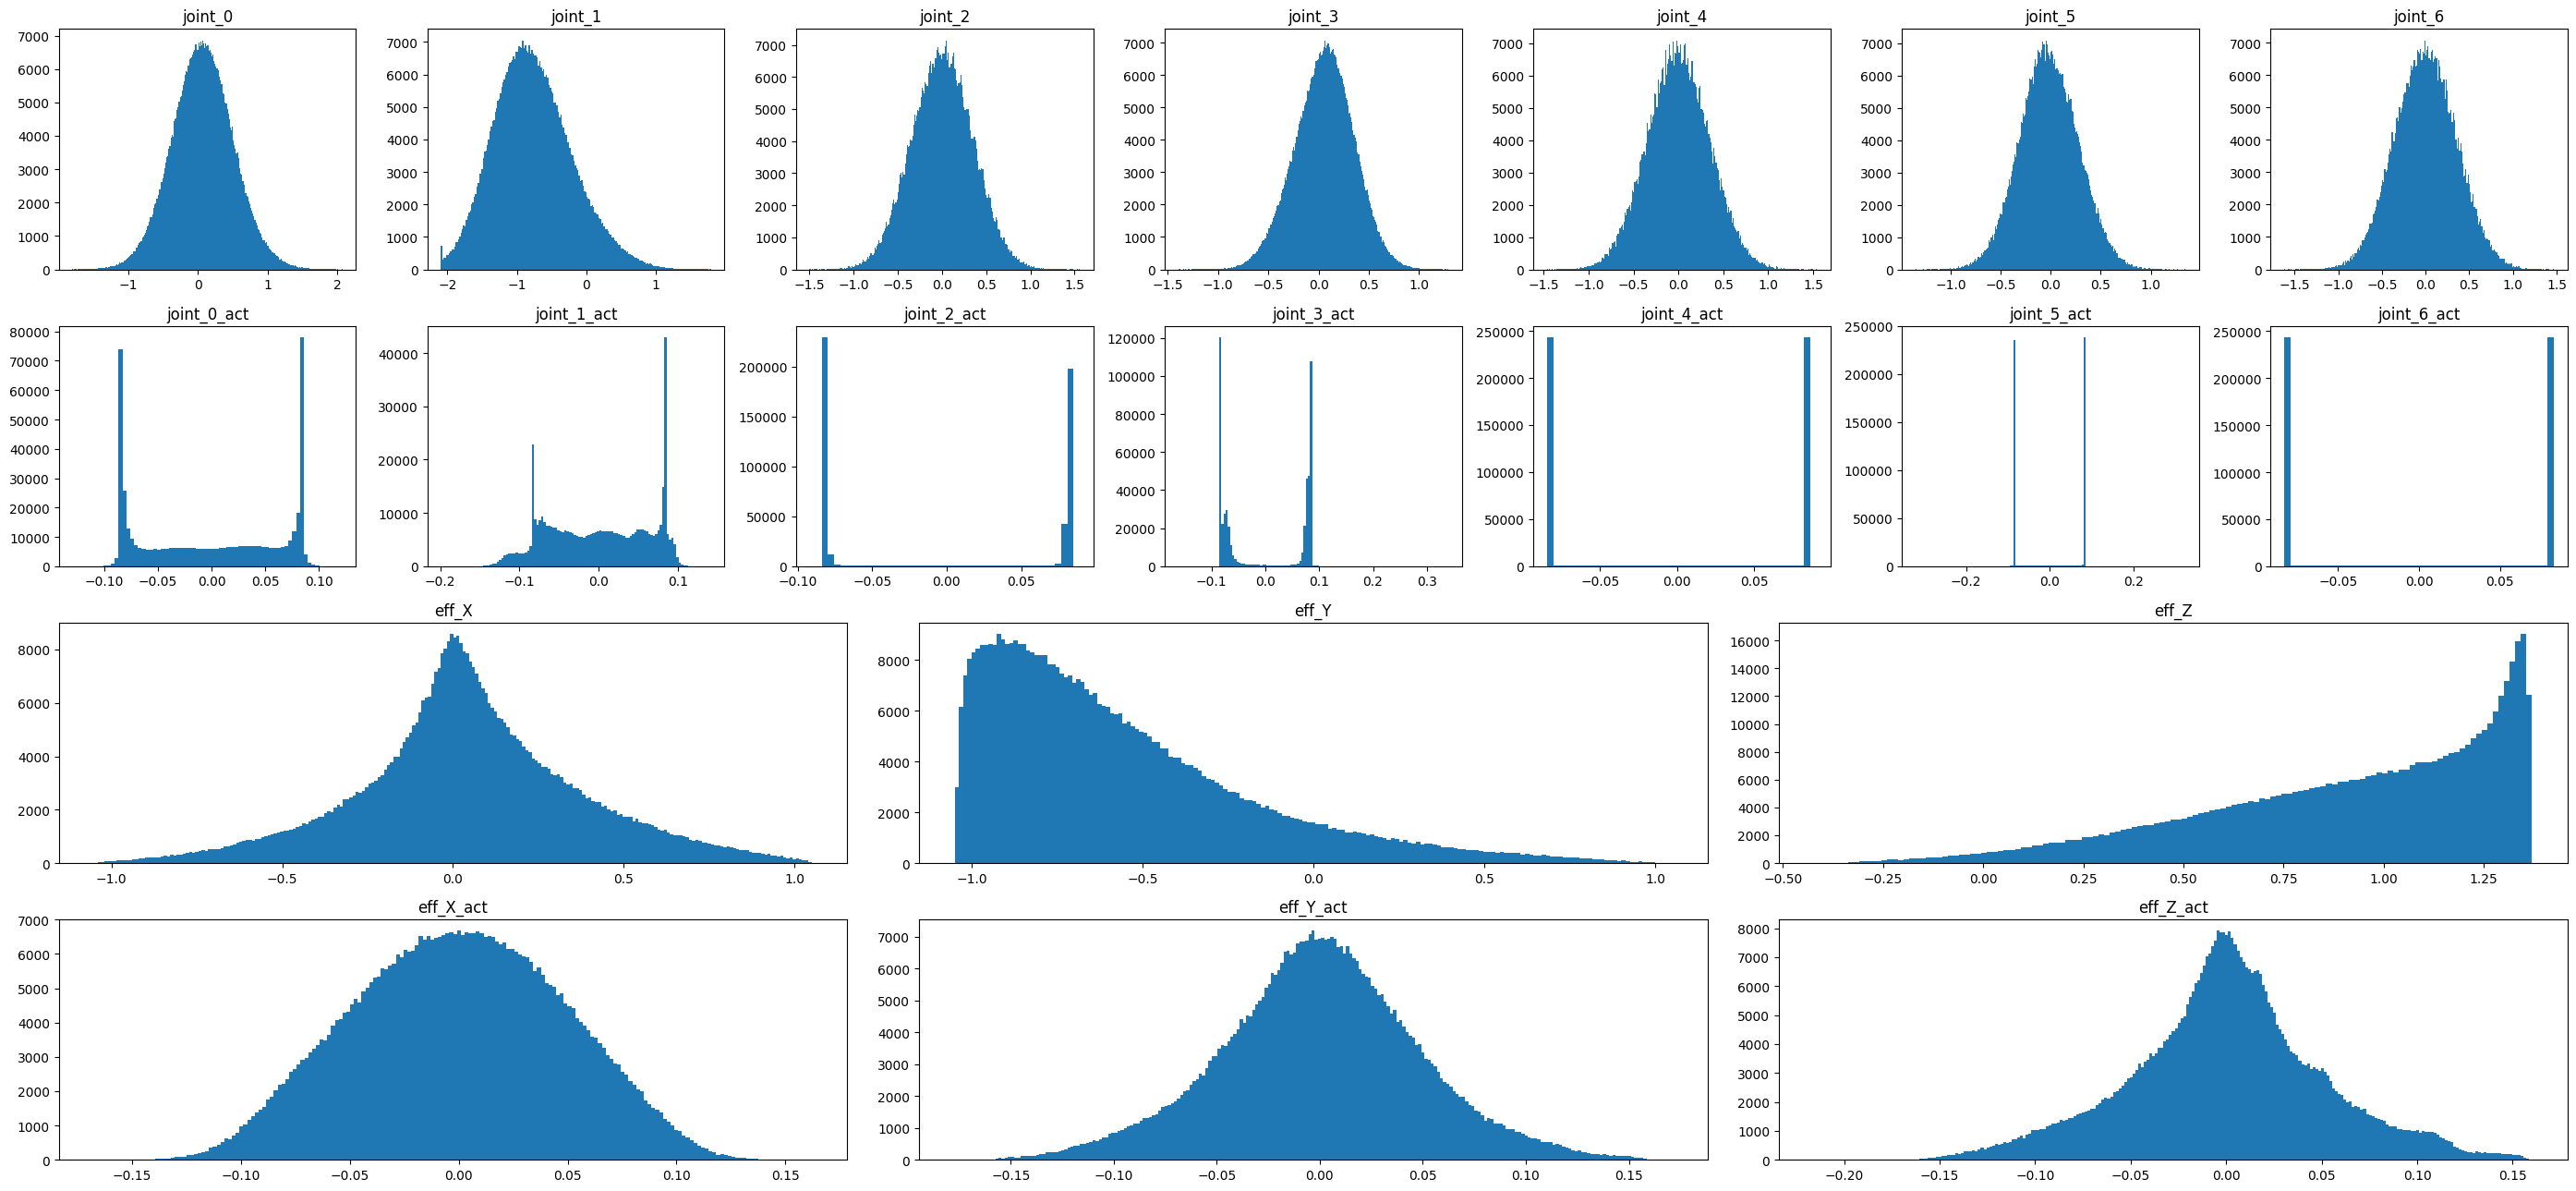

In [16]:
import matplotlib.pyplot as plt

rows = [
    ['joint_0', 'joint_1', 'joint_2', 'joint_3', 'joint_4', 'joint_5', 'joint_6'],
    ['joint_0_act', 'joint_1_act', 'joint_2_act', 'joint_3_act', 'joint_4_act', 'joint_5_act', 'joint_6_act'],
    ['eff_X', 'eff_Y', 'eff_Z']
]

fig = plt.figure(figsize=(28, 13))
gs = fig.add_gridspec(4, 21)

for i, row in enumerate(rows):
    width = 21 // len(row)
    
    for j, col_name in enumerate(row):
        ax = fig.add_subplot(gs[i, j * width : (j + 1) * width])
        
        ax.hist(kuka_fwd[:, fwd_col_idx[col_name]], bins='auto')
        ax.set_title(col_name)

for j, col_name in enumerate(['eff_X_act', 'eff_Y_act', 'eff_Z_act']):
    width = 7
    ax = fig.add_subplot(gs[3, j * width : (j + 1) * width])
    
    ax.hist(eff_data[:, j], bins='auto')
    ax.set_title(col_name)

plt.tight_layout()
plt.savefig('../../plots/kuka/kinematics/kuka_hist.png')
# plt.show()

<Figure size 640x480 with 0 Axes>

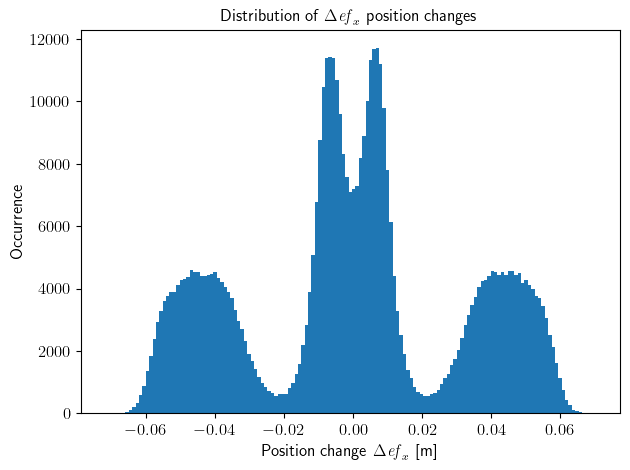

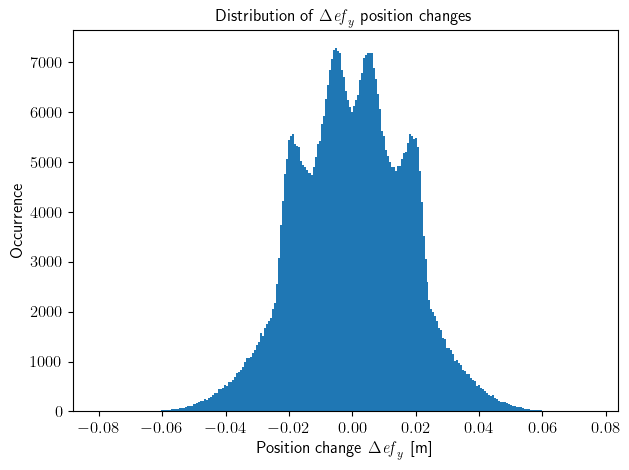

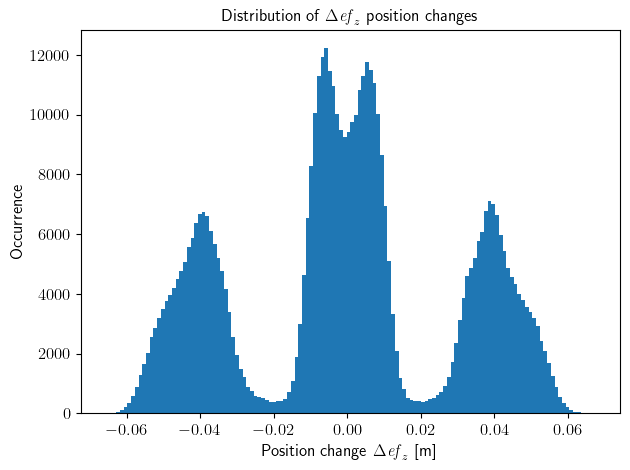

In [37]:
import matplotlib.pyplot as plt

plt.clf()
rc = {
    'font.family': 'serif',
    'text.usetex': True,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'svg.fonttype': 'none'
}

tex_names = {
    'joint_0': r'\theta_0', 'joint_1': r'\theta_1', 'joint_2': r'\theta_2', 'joint_3': r'\theta_3',
    'joint_4': r'\theta_4', 'joint_5': r'\theta_5', 'joint_6': r'\theta_6',
    'joint_0_act': 'a_0', 'joint_1_act': 'a_1', 'joint_2_act': 'a_2', 'joint_3_act': 'a_3', 
    'joint_4_act': 'a_4', 'joint_5_act': 'a_5', 'joint_6_act': 'a_6',
    'eff_X': r'\mathit{ef}_x', 'eff_Y': r'\mathit{ef}_y', 'eff_Z': r'\mathit{ef}_z',
    'eff_X_act': r'\Delta \mathit{ef}_x', 'eff_Y_act': r'\Delta \mathit{ef}_y', 'eff_Z_act': r'\Delta \mathit{ef}_z'
}

with plt.rc_context(rc):
    for j, col_name in enumerate(['eff_X_act', 'eff_Y_act', 'eff_Z_act']): 
        # col_name = 'joint_0'
        
        fig, ax = plt.subplots(layout='tight')
        # ax.hist(panda_fwd[:, fwd_col_idx[col_name]], bins='auto')
        ax.hist(eff_data[:, j], bins='auto')
        
        ax.set_title(fr'Distribution of ${tex_names[col_name]}$ position changes', fontsize=12)
        ax.set_xlabel(fr'Position change ${tex_names[col_name]}$ [m]', fontsize=12)
        ax.set_ylabel('Occurrence', fontsize=12)
        
        # plt.show()
        plt.savefig(f'../../plots/panda/distrib/{col_name}.svg')